In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor

# XGBoost

## 1. Load data

In [4]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

In [5]:
# Import features
file_path = 'Merged_dataset.csv'
df = pd.read_csv("merged_dataset.csv", sep=";", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.shape

(156, 184)

In [6]:
y = df.iloc[:, 0]   # første kolonne = inflation
X = df.iloc[:, 1:]  # resten = forklarende variable

# Tjek dimensioner
print("y shape:", y.shape)
print("X shape:", X.shape)

y shape: (156,)
X shape: (156, 183)


## 2. Imputer manglende værdier

In [8]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(X)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X = pd.DataFrame(X_imputed, columns=X.columns, index = df.index)

## 3. Standardiser data 

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run XGBoost model

In [12]:
# XGBoost bruger sin egen data-struktur kaldet DMatrix for effektivitet
dtrain = xgb.DMatrix(X_scaled, label=y)

In [13]:
# Definér parametre for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression
    'eval_metric': 'rmse',            # Root Mean Square Error
    'eta': 0.1,                       # Learning rate
    'max_depth': 8,                   # Maksimal trædybde
    'subsample': 0.8,                 # Andel af data til træning af hvert træ
    'colsample_bytree': 0.8           # Andel af features til træning af hvert træ
}

In [14]:
# Træn modellen
num_boost_round = 100

model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

In [15]:
#xgb.plot_importance(model)
#plt.show()

In [16]:
# Lav forudsigelser
X_new = X.iloc[[-1]]  # Henter den sidste række som en DataFrame

X_new_scaled = scaler.transform(X_new)
dnew = xgb.DMatrix(X_new_scaled)
y_pred = model.predict(dnew)

In [17]:
y_pred

array([1.8837363], dtype=float32)

# Simple forecasting model

In [19]:
forecast_horizons = 12
xgb_models = {}

for h in range(forecast_horizons):
    print(f"\n=== Horisont {h} ===")
    
    # Skift målvariablen for at skabe fremtidige værdier
    y_shifted = y.shift(-h).dropna()
    
    # Match features til den skiftede målvariabel
    X_train = X_scaled[:len(y_shifted)]
    y_train = y_shifted
    
    # Definér XGBoost-modellen
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42
    )
    
    # Træn modellen
    model.fit(X_train, y_train)
    
    # Gem den trænede model
    xgb_models[h] = model
    
    print(f"Antal træningsobservationer: {len(y_train)}")
    print(f"Antal features brugt: {X_train.shape[1]}")
    
# Tag seneste observation (det du forudsiger ud fra)
latest_data_df = X.iloc[[-1]]  
latest_data_scaled = scaler.transform(latest_data_df)

xgb_forecasts = {}
for h in range(0, forecast_horizons):
    forecast = xgb_models[h].predict(latest_data_scaled)
    xgb_forecasts[h] = forecast[0]  # Gem som float


=== Horisont 0 ===
Antal træningsobservationer: 156
Antal features brugt: 183

=== Horisont 1 ===
Antal træningsobservationer: 155
Antal features brugt: 183

=== Horisont 2 ===
Antal træningsobservationer: 154
Antal features brugt: 183

=== Horisont 3 ===
Antal træningsobservationer: 153
Antal features brugt: 183

=== Horisont 4 ===
Antal træningsobservationer: 152
Antal features brugt: 183

=== Horisont 5 ===
Antal træningsobservationer: 151
Antal features brugt: 183

=== Horisont 6 ===
Antal træningsobservationer: 150
Antal features brugt: 183

=== Horisont 7 ===
Antal træningsobservationer: 149
Antal features brugt: 183

=== Horisont 8 ===
Antal træningsobservationer: 148
Antal features brugt: 183

=== Horisont 9 ===
Antal træningsobservationer: 147
Antal features brugt: 183

=== Horisont 10 ===
Antal træningsobservationer: 146
Antal features brugt: 183

=== Horisont 11 ===
Antal træningsobservationer: 145
Antal features brugt: 183


In [20]:
xgb_forecasts

{0: 1.884315,
 1: 1.4124293,
 2: 3.1410902,
 3: 2.2161474,
 4: 1.5374182,
 5: 1.8805789,
 6: 5.940653,
 7: 6.0276923,
 8: 5.560633,
 9: 3.8218224,
 10: 1.1985494,
 11: 1.419448}

# Grid search

In [22]:

# Definér søgeområder
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  # Antal tilfældige kombinationer at prøve
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Bedste parametre:", random_search.best_params_)
print("RMSE (neg):", random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Bedste parametre: {'colsample_bytree': 0.6298202574719083, 'learning_rate': 0.3060660809801552, 'max_depth': 3, 'n_estimators': 235, 'subsample': 0.602208846849441}
RMSE (neg): -1.826990456886114


In [23]:
best_params = {
    'colsample_bytree': 0.6298202574719083,
    'learning_rate': 0.3060660809801552,
    'max_depth': 3,
    'n_estimators': 235,
    'subsample': 0.602208846849441
}

best_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6298202574719083, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3060660809801552, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=235, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# New updated forcast model

In [25]:
forecast_horizons = 12
xgb_models = {}

# Bedste fundne parametre fra RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.6298202574719083,
    'learning_rate': 0.3060660809801552,
    'max_depth': 3,
    'n_estimators': 235,
    'subsample': 0.602208846849441
}

for h in range(forecast_horizons):
    print(f"\n=== Horisont {h+1} ===")
    
    y_shifted = y.shift(-h).dropna()
    X_train = X_scaled[:len(y_shifted)]
    y_train = y_shifted

    # Brug tuned model
    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params
    )
    
    model.fit(X_train, y_train)
    xgb_models[h] = model

    print(f"Antal træningsobservationer: {len(y_train)}")
    print(f"Antal features brugt: {X_train.shape[1]}")
    
# Seneste datapunkt
latest_data_df = X.iloc[[-1]]
latest_data_scaled = scaler.transform(latest_data_df)

xgb_forecasts = {}
for h in range(forecast_horizons):
    forecast = xgb_models[h].predict(latest_data_scaled)
    xgb_forecasts[h] = forecast[0]


=== Horisont 1 ===
Antal træningsobservationer: 156
Antal features brugt: 183

=== Horisont 2 ===
Antal træningsobservationer: 155
Antal features brugt: 183

=== Horisont 3 ===
Antal træningsobservationer: 154
Antal features brugt: 183

=== Horisont 4 ===
Antal træningsobservationer: 153
Antal features brugt: 183

=== Horisont 5 ===
Antal træningsobservationer: 152
Antal features brugt: 183

=== Horisont 6 ===
Antal træningsobservationer: 151
Antal features brugt: 183

=== Horisont 7 ===
Antal træningsobservationer: 150
Antal features brugt: 183

=== Horisont 8 ===
Antal træningsobservationer: 149
Antal features brugt: 183

=== Horisont 9 ===
Antal træningsobservationer: 148
Antal features brugt: 183

=== Horisont 10 ===
Antal træningsobservationer: 147
Antal features brugt: 183

=== Horisont 11 ===
Antal træningsobservationer: 146
Antal features brugt: 183

=== Horisont 12 ===
Antal træningsobservationer: 145
Antal features brugt: 183


In [26]:
xgb_forecasts

{0: 1.884772,
 1: 1.8549323,
 2: 3.1271367,
 3: 2.0874026,
 4: 2.9037254,
 5: 1.4364549,
 6: 2.1037552,
 7: 2.5876338,
 8: 2.9687889,
 9: 1.6013173,
 10: 1.1018327,
 11: 1.8120364}

# Forcast with rolling windue

In [28]:
from xgboost import XGBRegressor
import pandas as pd

def XGBoost_Forecaster_Rolling(X, y, forecast_horizon, last_observation_date, scaler, window_length=108, verbose=True):
    """
    Forecast inflation using one XGBoost model per horizon (direct forecast), based on Garcia et al. (2017)
    
    Args:
        X: DataFrame of predictors
        y: Series of target variable
        forecast_horizon: int, how many months ahead to forecast
        last_observation_date: str or Timestamp, point of forecast
        scaler: fitted sklearn scaler
        window_length: int, rolling window length (default: 108 months)
        verbose: print training details
    """

    # 1. Begræns data til real-time
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]

    if len(X) < window_length:
        raise ValueError("Not enough data for the rolling window.")

    # 2. Træk rolling window
    X_window = X.iloc[-window_length:]
    y_window = y.iloc[-window_length:]

    xgb_models = {}

    # 3. Træn én XGBoost-model per horisont
    for h in range(forecast_horizon):
        if verbose: 
            print(f"\n=== Horisont h={h+1} ===")
        
        y_shifted = y_window.shift(-h).dropna()
        X_train = X_window.iloc[:len(y_shifted)]
        y_train = y_shifted

        # Skalér input
        X_train_scaled = scaler.transform(X_train)

        # Brug evt. dine tuned parametre her
        model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=235,
            learning_rate=0.306066,
            max_depth=3,
            subsample=0.6022,
            colsample_bytree=0.6298,
            random_state=42
        )

        model.fit(X_train_scaled, y_train)
        xgb_models[h] = model

        if verbose:
            print(f"Antal træningsobservationer: {len(y_train)}")
            print(f"Antal features: {X_train.shape[1]}")

    # 4. Lav forecast fra seneste datapunkt
    X_t = X.loc[[last_observation_date]]
    X_t_scaled = scaler.transform(X_t)

    xgb_forecasts = {}
    for h in range(forecast_horizon):
        forecast = xgb_models[h].predict(X_t_scaled)
        xgb_forecasts[h] = forecast[0]

    # 5. Formatér output
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in xgb_forecasts.keys()]

    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(xgb_forecasts.values()),
        "Horizon": list(xgb_forecasts.keys())
    })

    if verbose:
        print("\nForudsagte måneder:")
        for date in forecast_dates:
            print(date.strftime("%Y-%m"))

    return forecast_df


In [29]:
xgb_result = XGBoost_Forecaster_Rolling(
    X=X,
    y=y,
    forecast_horizon=12,
    last_observation_date="2024-12-01",
    scaler=scaler,
    window_length=108,
    verbose=True
)



=== Horisont h=1 ===
Antal træningsobservationer: 108
Antal features: 183

=== Horisont h=2 ===
Antal træningsobservationer: 107
Antal features: 183

=== Horisont h=3 ===
Antal træningsobservationer: 106
Antal features: 183

=== Horisont h=4 ===
Antal træningsobservationer: 105
Antal features: 183

=== Horisont h=5 ===
Antal træningsobservationer: 104
Antal features: 183

=== Horisont h=6 ===
Antal træningsobservationer: 103
Antal features: 183

=== Horisont h=7 ===
Antal træningsobservationer: 102
Antal features: 183

=== Horisont h=8 ===
Antal træningsobservationer: 101
Antal features: 183

=== Horisont h=9 ===
Antal træningsobservationer: 100
Antal features: 183

=== Horisont h=10 ===
Antal træningsobservationer: 99
Antal features: 183

=== Horisont h=11 ===
Antal træningsobservationer: 98
Antal features: 183

=== Horisont h=12 ===
Antal træningsobservationer: 97
Antal features: 183

Forudsagte måneder:
2025-01
2025-02
2025-03
2025-04
2025-05
2025-06
2025-07
2025-08
2025-09
2025-10

In [30]:
xgb_result

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.884962,0
1,2025-02-01,2.217614,1
2,2025-03-01,2.126257,2
3,2025-04-01,3.327068,3
4,2025-05-01,3.544109,4
5,2025-06-01,1.652131,5
6,2025-07-01,1.773021,6
7,2025-08-01,2.938632,7
8,2025-09-01,2.950404,8
9,2025-10-01,1.572531,9


# Rolling forecasts

In [32]:
def run_rolling_forecast(X, y, forecast_horizon=12, start_date="2012-01", end_date="2015-12", window_length=72):
    """
    Kører rolling real-time forecast med Random Forest, én forecast per måned (med 12 horisonter per gang)
    """

    all_forecasts = []

    forecast_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for date in forecast_dates:
        print(f"\n=== Forecast lavet i: {date.strftime('%Y-%m')} ===")

        # Real-time datasæt
        X_train = X.loc[:date]
        y_train = y.loc[:date]

        if len(X_train) < window_length:
            print("Springer over pga. for lidt data.")
            continue

        # Skaler træningsdata (rolling window)
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[-window_length:])

        # Lav forecast for 12 horisonter
        forecast_df = XGBoost_Forecaster_Rolling(
            X=X,
            y=y,
            forecast_horizon=forecast_horizon,
            last_observation_date=date,
            scaler=scaler,
            window_length=window_length, 
            verbose=False
        )


        forecast_df["Forecast_made_in"] = date  # hvornår forecast blev lavet
        all_forecasts.append(forecast_df)

    all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    return all_forecasts_df


In [33]:
forecast_results = run_rolling_forecast(X, y, forecast_horizon=12, start_date="2023-01-01", end_date="2024-12-01")


=== Forecast lavet i: 2023-01 ===

=== Forecast lavet i: 2023-02 ===

=== Forecast lavet i: 2023-03 ===

=== Forecast lavet i: 2023-04 ===

=== Forecast lavet i: 2023-05 ===

=== Forecast lavet i: 2023-06 ===

=== Forecast lavet i: 2023-07 ===

=== Forecast lavet i: 2023-08 ===

=== Forecast lavet i: 2023-09 ===

=== Forecast lavet i: 2023-10 ===

=== Forecast lavet i: 2023-11 ===

=== Forecast lavet i: 2023-12 ===

=== Forecast lavet i: 2024-01 ===

=== Forecast lavet i: 2024-02 ===

=== Forecast lavet i: 2024-03 ===

=== Forecast lavet i: 2024-04 ===

=== Forecast lavet i: 2024-05 ===

=== Forecast lavet i: 2024-06 ===

=== Forecast lavet i: 2024-07 ===

=== Forecast lavet i: 2024-08 ===

=== Forecast lavet i: 2024-09 ===

=== Forecast lavet i: 2024-10 ===

=== Forecast lavet i: 2024-11 ===

=== Forecast lavet i: 2024-12 ===


In [34]:
forecast_results

,Dato,Inflationsforecast,Horizon,Forecast_made_in
0,2023-02-01,7.677856,0,2023-01-01
1,2023-03-01,8.329760,1,2023-01-01
2,2023-04-01,8.657200,2,2023-01-01
3,2023-05-01,8.386595,3,2023-01-01
4,2023-06-01,8.119694,4,2023-01-01
...,...,...,...,...
283,2025-08-01,3.179909,7,2024-12-01
284,2025-09-01,1.817548,8,2024-12-01
285,2025-10-01,2.682903,9,2024-12-01
286,2025-11-01,1.564058,10,2024-12-01


In [35]:
def evaluate_forecasts(forecast_df, y):
    """
    Matcher forecast med y_true og returnerer RMSE og MAE pr. horisont
    """
    # Merge forecast og faktisk inflation
    merged = forecast_df.merge(
        y.rename("y_true"), 
        left_on="Dato", 
        right_index=True,
        how="left"
    )

    # Filtrer ud fremtid hvor vi ikke har faktisk inflation
    merged = merged.dropna(subset=["y_true"])

    # Beregn fejl
    merged["error"] = merged["Inflationsforecast"] - merged["y_true"]
    merged["abs_error"] = merged["error"].abs()
    merged["squared_error"] = merged["error"] ** 2

    # Evaluer pr. horisont
    evaluation = merged.groupby("Horizon").agg(
        MAE=("abs_error", "mean"),
        RMSE=("squared_error", lambda x: (x.mean())**0.5),
        N_obs=("y_true", "count")
    ).reset_index()

    return evaluation, merged


In [36]:
eval_df, merged_df = evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.618646,0.840438,23
1,1,1.490000,2.103066,22
2,2,1.675542,2.318603,21
3,3,1.967968,2.511761,20
4,4,2.325284,2.924665,19
5,5,2.304837,3.251199,18
6,6,2.434668,3.496595,17
7,7,3.379603,4.188641,16
8,8,4.349086,4.756813,15
9,9,4.541494,5.029087,14


In [37]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.677856,0,2023-01-01,7.601,0.076856,0.076856,0.005907
12,2023-03-01,7.600915,0,2023-02-01,6.733,0.867915,0.867915,0.753276
24,2023-04-01,6.733448,0,2023-03-01,5.282,1.451448,1.451448,2.106700
36,2023-05-01,5.282172,0,2023-04-01,2.928,2.354172,2.354172,5.542125
48,2023-06-01,2.928376,0,2023-05-01,2.465,0.463376,0.463376,0.214718
60,2023-07-01,2.465018,0,2023-06-01,3.133,-0.667982,0.667982,0.446200
72,2023-08-01,3.133242,0,2023-07-01,2.437,0.696242,0.696242,0.484752
84,2023-09-01,2.437362,0,2023-08-01,0.859,1.578362,1.578362,2.491228
96,2023-10-01,0.859553,0,2023-09-01,0.085,0.774553,0.774553,0.599933
108,2023-11-01,0.085192,0,2023-10-01,0.600,-0.514808,0.514808,0.265027


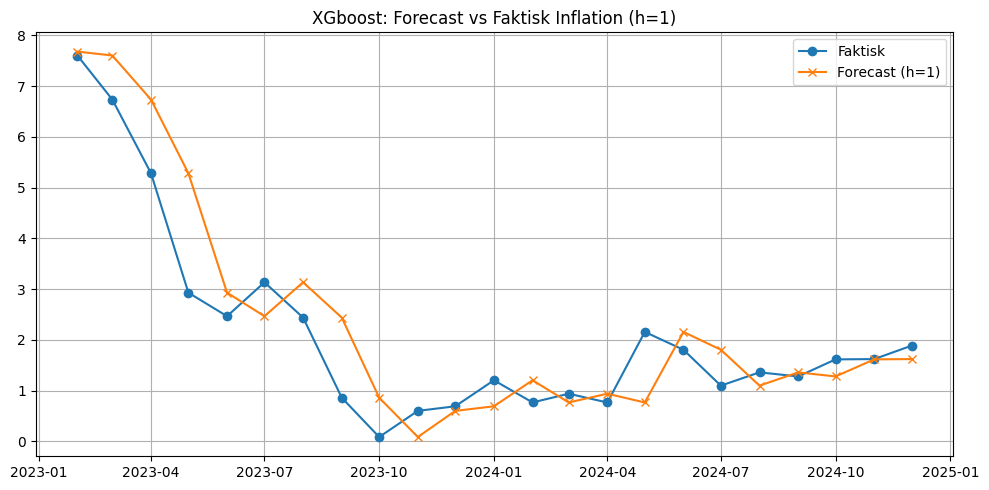

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Dato"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Dato"], h1["Inflationsforecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("XGboost: Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()